## Data Gathering


In [1]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import requests

# To unzip the edf_dataset
import zipfile
import os

# EDFlib and Data Preprocesing module
from mne.preprocessing import ICA, create_eog_epochs
import mne
from pyedflib import highlevel
import pyedflib as plib

In [2]:
import requests


def download_file(url, save_path):

    # Check if the file already exists
    if os.path.exists(save_path):
        print(f"File already exists at '{save_path}'. Skipping download.")
        return  # Exit the function if the file exists

    # Send a GET request to the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Open the file in binary write mode and save the content
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded successfully and saved to '{save_path}'")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")


# Specify the URL and the path where you want to save the file
url = 'https://figshare.com/ndownloader/articles/4244171/versions/2'
# Change this to your desired path
save_path = './edf_dataset.zip'

# Call the function to download the file
download_file(url, save_path)

File already exists at './edf_dataset.zip'. Skipping download.


In [3]:
def unzip_file(zip_file_path, extract_to_folder):

    # Check if the directory exist
    
    if os.path.exists(extract_to_folder):
        print(f"Directory '{extract_to_folder} already exists")
        return # Exit the function if the directory
    
    # Create the directory if it doesn't exist
    os.makedirs(extract_to_folder, exist_ok=True)

    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents into the specified folder
        zip_ref.extractall(extract_to_folder)


# Specify the path to the zip file and the extraction folder
zip_file_path = './edf_dataset.zip'
# Change this if needed
extract_to_folder = './edf_dataset_2'

# Call the function to unzip
unzip_file(zip_file_path, extract_to_folder)


Directory './edf_dataset_2 already exists


In [4]:
import os
import re

edf_directory = "./edf_dataset_2"

for filename in os.listdir(edf_directory):
    new_filename = filename
    
    # Handle spaces in filename
    if ' ' in new_filename:
        new_filename = re.sub(r'\s+', '_', new_filename)
    
    # Handle subject numbers (S1 -> S01)
    new_filename = re.sub(r'S(\d)(?!\d)', r'S0\1', new_filename)
    
    # Handle filenames containing '6931959'
    if '6931959' in new_filename:
        new_filename = new_filename.replace('6931959_', '')
    
    # Handle filenames containing '6921143'
    if '6921143' in new_filename:
        new_filename = new_filename.replace('6921143_', '')
    
    # Zero-pad other single-digit numbers in filenames
    new_filename = re.sub(r'(?<!\d)(\d)(?!\d)', r'0\1', new_filename)
    
    # Only rename if the filename has changed
    if new_filename != filename:
        old_file = os.path.join(edf_directory, filename)
        new_file = os.path.join(edf_directory, new_filename)
        
        os.rename(old_file, new_file)
        print(f'Renamed: "{filename}" to "{new_filename}"')

print("Renaming complete.")

Renaming complete.


## Individual Preprocessing Functions


In [5]:
# Function to rename channels and drop specified channels based on conditions
def process_channels(raw_data):
    """
    Process and standardize EEG channels to keep only the 17 most common channels.
    """
    print(f"Initial channels: {raw_data.ch_names}")

    # Initialize a list to hold channels to drop
    channels_to_drop = []

    # Create mapping for channel renaming
    rename_map = {}
    for name in raw_data.ch_names:
        if any(x in name for x in ['23A-23R', '24A-24R', 'A2-A1']):
            channels_to_drop.append(name)
        else:
            new_name = name.replace('EEG ', '').replace('-LE', '')
            rename_map[name] = new_name

    # Drop unwanted channels
    if channels_to_drop:
        print(f"Dropping channels: {channels_to_drop}")
        raw_data.drop_channels(channels_to_drop)

    # Rename remaining channels
    raw_data.rename_channels(rename_map)

    print(f"Final channels: {raw_data.ch_names}")

    # Define the 17 most common channels
    expected_channels = [
        'Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'Fp2',
        'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz'
    ]

    # Keep only the expected channels
    channels_to_keep = set(expected_channels)
    channels_to_drop = [
        ch for ch in raw_data.ch_names if ch not in channels_to_keep]

    if channels_to_drop:
        print(
            f"Dropping channels to keep only the expected 17 channels: {channels_to_drop}")
        raw_data.drop_channels(channels_to_drop)

    # Verify we have the expected number of channels (should be 17)
    if len(raw_data.ch_names) != len(expected_channels):
        print(
            f"Warning: Expected {len(expected_channels)} channels, got {len(raw_data.ch_names)}")
        print(f"Missing: {set(expected_channels) - set(raw_data.ch_names)}")

    return raw_data

In [6]:
all_edf_files = os.listdir(edf_directory)
ec_file_path = [i for i in all_edf_files if i.endswith('EC.edf')]
eo_file_path = [i for i in all_edf_files if i.endswith('EO.edf')]
task_file_path = [i for i in all_edf_files if i.endswith('TASK.edf')]

print(len(all_edf_files), len(ec_file_path), len(eo_file_path), len(task_file_path))

180 58 61 61


In [7]:
def read_data(file_path):
    data = mne.io.read_raw_edf(file_path, preload=True)
    data.set_eeg_reference()
    return data
    

In [8]:
def bandpass_filter(data, l_freq, h_freq):
    # Adjust the filter parameters as needed
    data.filter(l_freq=l_freq, h_freq=h_freq)

In [9]:
def preprocess_ICA(raw, n_components ):
    print(f"Preprocessing ICA: {raw.filenames}")

    ica = ICA(n_components=n_components,random_state=97,
              max_iter=800) 
    ica.fit(raw)
    return ica

In [11]:
# Directory containing the EDF files
edf_directory = "./edf_dataset_2"  # Adjust this path to your dataset location

# Initialize lists
processed_raw_data = []
class_counts = {'Healthy': 0, 'MDD': 0}

# Read all EDF files
for filename in os.listdir(edf_directory):
    if filename.endswith('.edf'):
        file_path = os.path.join(edf_directory, filename)
        try:
            # Read the raw data
            raw_data = read_data(file_path)

            if raw_data is not None:
                processed_raw_data.append(raw_data)
                print(f"Successfully loaded: {filename}")
            else:
                print(f"Failed to load: {filename}")

        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
            continue

print(f"\nTotal files loaded: {len(processed_raw_data)}")

Extracting EDF parameters from c:\Capstone\depression-detection-eeg-python\edf_dataset_2\H_S01_EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Successfully loaded: H_S01_EC.edf
Extracting EDF parameters from c:\Capstone\depression-detection-eeg-python\edf_dataset_2\H_S01_EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 89855  =      0.000 ...   350.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Successfully loaded: H_S01_EO.edf
Extracting EDF parameters from c:\Capstone\depression-detection-eeg-python\edf_dataset_2\H_S01_TASK.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 154879  =      0.0

## Full Preprocessing Function


In [ ]:
def preprocess_eeg(raw_data, l_freq=0.5, h_freq=50.0, n_components=5, time_steps=5, samples_per_step=256):
    """
    Complete EEG preprocessing pipeline: bandpass -> ICA -> reshape for CNN-LSTM
    """
    try:
        print(f"\nProcessing file: {raw_data.filenames}")
        
        processed_raw = process_channels(raw_data=raw_data)

        # 1. Bandpass filtering
        print("1. Applying bandpass filter...")
        bandpass_filter(processed_raw, l_freq, h_freq)

        # 2. ICA
        print("2. Applying ICA...")
        ica = preprocess_ICA(processed_raw, n_components)
        ica.apply(processed_raw)
        
        # 3. Normalization (Z-score normalization per channel)
        print("3. Normalizing data...")
        # Extract the data array from the processed_raw object
        # Shape: (n_channels, n_samples)
        data = processed_raw.get_data()
        # Use Z-score normalization: subtract channel-wise mean and divide by channel-wise std dev
        epsilon = 1e-10  # small constant to prevent division by zero
        data = (data - np.mean(data, axis=1, keepdims=True)) / (np.std(data, axis=1, keepdims=True) + epsilon)

        # 4. Reshape data for CNN-LSTM
        print("4. Reshaping data for CNN-LSTM...")
        data = processed_raw.get_data()
        n_channels = data.shape[0]
        
        # Calculate total samples needed for each complete sequence
        total_samples_per_sequence = time_steps * samples_per_step
        
        # Determine how many complete sequences we can make
        n_sequences = data.shape[1] // total_samples_per_sequence
        
        # Reshape the data
        reshaped_data = []
        for i in range(n_sequences):
            start = i * total_samples_per_sequence
            end = start + total_samples_per_sequence
            sequence = data[:, start:end]
            
            # Reshape into (time_steps, channels, samples_per_step)
            sequence = sequence.reshape(time_steps, n_channels, samples_per_step)
            
            # Transpose to (time_steps, channels, samples_per_step)
            sequence = np.transpose(sequence, (0, 2, 1))
            
            reshaped_data.append(sequence)
        
        # Convert to numpy array and add channel dimension
        final_data = np.array(reshaped_data)[..., np.newaxis]
        
        print(f"Reshaping completed. Final data shape: {final_data.shape}")
        return final_data

    except Exception as e:
        print(f"Preprocessing error: {str(e)}")
        return None


## Preprocessing


In [13]:
# Now process each raw data file
X_data = []
y_labels = []
class_counts = {'Healthy': 0, 'MDD': 0}

print("\nStarting preprocessing pipeline...")
for raw_data in processed_raw_data:
    filename = os.path.basename(raw_data.filenames[0])
    print(f"\n{'='*50}")
    print(f"Processing: {filename}")
    print(f"Initial data info:")
    print(f"Channels: {raw_data.ch_names}")
    print(f"Sample rate: {raw_data.info['sfreq']} Hz")
    print(f"Duration: {raw_data.n_times / raw_data.info['sfreq']:.2f} seconds")

    # Apply complete preprocessing pipeline
    try:
        # First, process the channels
        # Make a copy to prevent modifying original
        raw_data = process_channels(raw_data.copy()) 
        print(f"Channels after processing: {raw_data.ch_names}")

        # Apply complete preprocessing pipeline
        processed_data = preprocess_eeg(
            raw_data, l_freq=0.5, h_freq=50.0, n_components=5, time_steps=5, samples_per_step=256
        )

        if processed_data is not None:
            print(f"Processed data shape: {processed_data.shape}")

            # Create label (1 for MDD, 0 for Healthy)
            label = 1 if filename.startswith('MDD') else 0

            # Update counts with number of epochs
            if label == 1:
                class_counts['MDD'] += processed_data.shape[0]
            else:
                class_counts['Healthy'] += processed_data.shape[0]

            # Append to lists
            X_data.append(processed_data)
            y_labels.extend([label] * processed_data.shape[0])
            print(f"Successfully processed {filename}")
        else:
            print(f"Failed to process {filename}")

    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")
        continue

    print(f"{'='*50}\n")


# Print final summary
print("\nProcessing Summary:")
print(f"Total files processed: {len(processed_raw_data)}")
print(f"Total epochs: {len(y_labels)}")
print(f"Successfully processed files: {len(X_data)}")
print(f"Failed files: {len(processed_raw_data) - len(X_data)}")
print("\nClass distribution:")
print(f"MDD epochs: {class_counts['MDD']}")
print(f"Healthy epochs: {class_counts['Healthy']}")
# print(f"\nChannels used: {raw_data.ch_names}")

# # Optional: Print class balance percentage
# total_epochs = class_counts['MDD'] + class_counts['Healthy']
# print("\nClass balance:")
# print(f"MDD: {(class_counts['MDD']/total_epochs)*100:.2f}%")
# print(f"Healthy: {(class_counts['Healthy']/total_epochs)*100:.2f}%")


Starting preprocessing pipeline...

Processing: H_S01_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5'

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

2. Applying ICA...
Preprocessing ICA: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S01_EC.edf',)
Fitting ICA to data using 17 channels (please be patient, this may take a while)
Selecting by number: 5 components


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:312: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:312: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S01_EC.edf


Processing: H_S01_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 351.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (70, 5, 256, 17, 1)
Processed data shape: (70, 5, 256, 17, 1)
Successfully processed H_S01_EO.edf


Processing: H_S01_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 605.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)
Processed data shape: (121, 5, 256, 17, 1)
Successfully processed H_S01_TASK.edf


Processing: H_S02_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE',

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S02_EC.edf


Processing: H_S02_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE'

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S02_EO.edf


Processing: H_S02_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 605.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)
Processed data shape: (121, 5, 256, 17, 1)
Successfully processed H_S02_TASK.edf


Processing: H_S03_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S03_EC.edf


Processing: H_S03_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 305.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (61, 5, 256, 17, 1)
Processed data shape: (61, 5, 256, 17, 1)
Successfully processed H_S03_EO.edf


Processing: H_S03_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 605.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)
Processed data shape: (121, 5, 256, 17, 1)
Successfully processed H_S03_TASK.edf


Processing: H_S04_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S04_EC.edf


Processing: H_S04_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 295.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed H_S04_EO.edf


Processing: H_S04_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 605.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)
Processed data shape: (121, 5, 256, 17, 1)
Successfully processed H_S04_TASK.edf


Processing: H_S05_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 303.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S05_EC.edf


Processing: H_S05_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 312.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (62, 5, 256, 17, 1)
Processed data shape: (62, 5, 256, 17, 1)
Successfully processed H_S05_EO.edf


Processing: H_S05_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 612.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (122, 5, 256, 17, 1)
Processed data shape: (122, 5, 256, 17, 1)
Successfully processed H_S05_TASK.edf


Processing: H_S06_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S06_EC.edf


Processing: H_S06_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 303.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S06_EO.edf


Processing: H_S06_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 611.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (122, 5, 256, 17, 1)
Processed data shape: (122, 5, 256, 17, 1)
Successfully processed H_S06_TASK.edf


Processing: H_S07_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 356.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (71, 5, 256, 17, 1)
Processed data shape: (71, 5, 256, 17, 1)
Successfully processed H_S07_EC.edf


Processing: H_S07_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 303.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S07_EO.edf


Processing: H_S07_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 605.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)
Processed data shape: (121, 5, 256, 17, 1)
Successfully processed H_S07_TASK.edf


Processing: H_S08_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S08_EC.edf


Processing: H_S08_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S08_EO.edf


Processing: H_S08_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 609.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 10.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)
Processed data shape: (121, 5, 256, 17, 1)
Successfully processed H_S08_TASK.edf


Processing: H_S09_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'E

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S09_EC.edf


Processing: H_S09_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S09_EO.edf


Processing: H_S09_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 601.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (120, 5, 256, 17, 1)
Processed data shape: (120, 5, 256, 17, 1)
Successfully processed H_S09_TASK.edf


Processing: H_S10_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 376.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (75, 5, 256, 17, 1)
Processed data shape: (75, 5, 256, 17, 1)
Successfully processed H_S10_EC.edf


Processing: H_S10_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S10_EO.edf


Processing: H_S10_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 605.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)
Processed data shape: (121, 5, 256, 17, 1)
Successfully processed H_S10_TASK.edf


Processing: H_S11_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S11_EC.edf


Processing: H_S11_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S11_EO.edf


Processing: H_S11_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 605.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)
Processed data shape: (121, 5, 256, 17, 1)
Successfully processed H_S11_TASK.edf


Processing: H_S12_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S12_EO.edf


Processing: H_S12_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 605.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)
Processed data shape: (121, 5, 256, 17, 1)
Successfully processed H_S12_TASK.edf


Processing: H_S13_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S13_EC.edf


Processing: H_S13_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 303.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S13_EO.edf


Processing: H_S13_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 610.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (122, 5, 256, 17, 1)
Processed data shape: (122, 5, 256, 17, 1)
Successfully processed H_S13_TASK.edf


Processing: H_S14_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S14_EC.edf


Processing: H_S14_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 194.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (38, 5, 256, 17, 1)
Processed data shape: (38, 5, 256, 17, 1)
Successfully processed H_S14_EO.edf


Processing: H_S14_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 607.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 23.9s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)
Processed data shape: (121, 5, 256, 17, 1)
Successfully processed H_S14_TASK.edf


Processing: H_S15_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'E

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S15_EC.edf


Processing: H_S15_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S15_EO.edf


Processing: H_S15_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 610.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (122, 5, 256, 17, 1)
Processed data shape: (122, 5, 256, 17, 1)
Successfully processed H_S15_TASK.edf


Processing: H_S16_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 292.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (58, 5, 256, 17, 1)
Processed data shape: (58, 5, 256, 17, 1)
Successfully processed H_S16_EC.edf


Processing: H_S16_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 299.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE'

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed H_S16_EO.edf


Processing: H_S16_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 634.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)
Processed data shape: (126, 5, 256, 17, 1)
Successfully processed H_S16_TASK.edf


Processing: H_S17_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 309.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (61, 5, 256, 17, 1)
Processed data shape: (61, 5, 256, 17, 1)
Successfully processed H_S17_EC.edf


Processing: H_S17_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S17_EO.edf


Processing: H_S17_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 605.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)
Processed data shape: (121, 5, 256, 17, 1)
Successfully processed H_S17_TASK.edf


Processing: H_S18_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S18_EO.edf


Processing: H_S18_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 608.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 29.9s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)
Processed data shape: (121, 5, 256, 17, 1)
Successfully processed H_S18_TASK.edf


Processing: H_S19_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'E

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0

Selecting by number: 5 components
Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S19_EC.edf


Processing: H_S19_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE',

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S19_EO.edf


Processing: H_S19_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 608.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)
Processed data shape: (121, 5, 256, 17, 1)
Successfully processed H_S19_TASK.edf


Processing: H_S20_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 307.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (61, 5, 256, 17, 1)
Processed data shape: (61, 5, 256, 17, 1)
Successfully processed H_S20_EC.edf


Processing: H_S20_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 320.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (64, 5, 256, 17, 1)
Processed data shape: (64, 5, 256, 17, 1)
Successfully processed H_S20_EO.edf


Processing: H_S21_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S21_EC.edf


Processing: H_S21_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 305.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 4.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (61, 5, 256, 17, 1)
Processed data shape: (61, 5, 256, 17, 1)
Successfully processed H_S21_EO.edf


Processing: H_S22_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S22_EC.edf


Processing: H_S22_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 299.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed H_S22_EO.edf


Processing: H_S22_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 604.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (120, 5, 256, 17, 1)
Processed data shape: (120, 5, 256, 17, 1)
Successfully processed H_S22_TASK.edf


Processing: H_S23_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S23_EC.edf


Processing: H_S23_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S23_EO.edf


Processing: H_S23_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 620.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 30.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (124, 5, 256, 17, 1)
Processed data shape: (124, 5, 256, 17, 1)
Successfully processed H_S23_TASK.edf


Processing: H_S24_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 299.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG P

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0

Selecting by number: 5 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed H_S24_EC.edf


Processing: H_S24_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 297.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed H_S24_EO.edf


Processing: H_S24_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 644.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (128, 5, 256, 17, 1)
Processed data shape: (128, 5, 256, 17, 1)
Successfully processed H_S24_TASK.edf


Processing: H_S25_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S25_EC.edf


Processing: H_S25_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 643.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (128, 5, 256, 17, 1)
Processed data shape: (128, 5, 256, 17, 1)
Successfully processed H_S25_TASK.edf


Processing: H_S26_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 13.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S26_EC.edf


Processing: H_S26_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 305.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (61, 5, 256, 17, 1)
Processed data shape: (61, 5, 256, 17, 1)
Successfully processed H_S26_EO.edf


Processing: H_S26_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 611.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (122, 5, 256, 17, 1)
Processed data shape: (122, 5, 256, 17, 1)
Successfully processed H_S26_TASK.edf


Processing: H_S27_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE',

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S27_EC.edf


Processing: H_S27_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE'

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S27_EO.edf


Processing: H_S27_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 633.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)
Processed data shape: (126, 5, 256, 17, 1)
Successfully processed H_S27_TASK.edf


Processing: H_S28_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S28_EC.edf


Processing: H_S28_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 299.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed H_S28_EO.edf


Processing: H_S28_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 607.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)
Processed data shape: (121, 5, 256, 17, 1)
Successfully processed H_S28_TASK.edf


Processing: H_S29_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 303.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S29_EC.edf


Processing: H_S29_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S29_EO.edf


Processing: H_S29_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 605.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)
Processed data shape: (121, 5, 256, 17, 1)
Successfully processed H_S29_TASK.edf


Processing: H_S30_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S30_EC.edf


Processing: H_S30_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE'

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed H_S30_EO.edf


Processing: H_S30_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 633.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)
Processed data shape: (126, 5, 256, 17, 1)
Successfully processed H_S30_TASK.edf


Processing: MDD_S01_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 303.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S01_EC.edf


Processing: MDD_S01_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S01_EO.edf


Processing: MDD_S01_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 632.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)
Processed data shape: (126, 5, 256, 17, 1)
Successfully processed MDD_S01_TASK.edf


Processing: MDD_S02_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 297.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed MDD_S02_EC.edf


Processing: MDD_S02_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 297.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed MDD_S02_EO.edf


Processing: MDD_S02_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 644.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (128, 5, 256, 17, 1)
Processed data shape: (128, 5, 256, 17, 1)
Successfully processed MDD_S02_TASK.edf


Processing: MDD_S03_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 180.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (36, 5, 256, 17, 1)
Processed data shape: (36, 5, 256, 17, 1)
Successfully processed MDD_S03_EC.edf


Processing: MDD_S03_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S03_EO.edf


Processing: MDD_S03_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 631.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)
Processed data shape: (126, 5, 256, 17, 1)
Successfully processed MDD_S03_TASK.edf


Processing: MDD_S04_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S04_EO.edf


Processing: MDD_S04_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 633.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)
Processed data shape: (126, 5, 256, 17, 1)
Successfully processed MDD_S04_TASK.edf


Processing: MDD_S05_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE',

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S05_EC.edf


Processing: MDD_S05_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S05_EO.edf


Processing: MDD_S05_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 614.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (122, 5, 256, 17, 1)
Processed data shape: (122, 5, 256, 17, 1)
Successfully processed MDD_S05_TASK.edf


Processing: MDD_S06_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S06_EC.edf


Processing: MDD_S06_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S06_EO.edf


Processing: MDD_S06_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 639.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (127, 5, 256, 17, 1)
Processed data shape: (127, 5, 256, 17, 1)
Successfully processed MDD_S06_TASK.edf


Processing: MDD_S07_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S07_EC.edf


Processing: MDD_S07_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 636.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (127, 5, 256, 17, 1)
Processed data shape: (127, 5, 256, 17, 1)
Successfully processed MDD_S07_TASK.edf


Processing: MDD_S08_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 607.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)
Processed data shape: (121, 5, 256, 17, 1)
Successfully processed MDD_S08_TASK.edf


Processing: MDD_S09_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S09_EC.edf


Processing: MDD_S09_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S09_EO.edf


Processing: MDD_S10_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S10_EC.edf


Processing: MDD_S10_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S10_EO.edf


Processing: MDD_S10_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 686.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (137, 5, 256, 17, 1)
Processed data shape: (137, 5, 256, 17, 1)
Successfully processed MDD_S10_TASK.edf


Processing: MDD_S11_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 299.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed MDD_S11_EC.edf


Processing: MDD_S11_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 299.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed MDD_S11_EO.edf


Processing: MDD_S11_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 637.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (127, 5, 256, 17, 1)
Processed data shape: (127, 5, 256, 17, 1)
Successfully processed MDD_S11_TASK.edf


Processing: MDD_S12_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 189.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (37, 5, 256, 17, 1)
Processed data shape: (37, 5, 256, 17, 1)
Successfully processed MDD_S12_EO.edf


Processing: MDD_S12_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 649.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (129, 5, 256, 17, 1)
Processed data shape: (129, 5, 256, 17, 1)
Successfully processed MDD_S12_TASK.edf


Processing: MDD_S13_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S13_EC.edf


Processing: MDD_S13_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 311.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (62, 5, 256, 17, 1)
Processed data shape: (62, 5, 256, 17, 1)
Successfully processed MDD_S13_EO.edf


Processing: MDD_S13_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 631.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)
Processed data shape: (126, 5, 256, 17, 1)
Successfully processed MDD_S13_TASK.edf


Processing: MDD_S14_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S14_EC.edf


Processing: MDD_S14_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S14_EO.edf


Processing: MDD_S14_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 635.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (127, 5, 256, 17, 1)
Processed data shape: (127, 5, 256, 17, 1)
Successfully processed MDD_S14_TASK.edf


Processing: MDD_S15_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S15_EC.edf


Processing: MDD_S15_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S15_EO.edf


Processing: MDD_S15_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 627.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (125, 5, 256, 17, 1)
Processed data shape: (125, 5, 256, 17, 1)
Successfully processed MDD_S15_TASK.edf


Processing: MDD_S16_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 298.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed MDD_S16_EO.edf


Processing: MDD_S16_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 638.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (127, 5, 256, 17, 1)
Processed data shape: (127, 5, 256, 17, 1)
Successfully processed MDD_S16_TASK.edf


Processing: MDD_S17_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 297.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed MDD_S17_EC.edf


Processing: MDD_S17_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 299.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed MDD_S17_EO.edf


Processing: MDD_S17_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 631.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)
Processed data shape: (126, 5, 256, 17, 1)
Successfully processed MDD_S17_TASK.edf


Processing: MDD_S18_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S18_EC.edf


Processing: MDD_S18_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S18_EO.edf


Processing: MDD_S18_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 636.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (127, 5, 256, 17, 1)
Processed data shape: (127, 5, 256, 17, 1)
Successfully processed MDD_S18_TASK.edf


Processing: MDD_S19_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 299.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed MDD_S19_EC.edf


Processing: MDD_S19_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 298.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed MDD_S19_EO.edf


Processing: MDD_S19_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 636.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (127, 5, 256, 17, 1)
Processed data shape: (127, 5, 256, 17, 1)
Successfully processed MDD_S19_TASK.edf


Processing: MDD_S20_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 299.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed MDD_S20_EC.edf


Processing: MDD_S20_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S20_EO.edf


Processing: MDD_S20_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 631.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)
Processed data shape: (126, 5, 256, 17, 1)
Successfully processed MDD_S20_TASK.edf


Processing: MDD_S21_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S21_EC.edf


Processing: MDD_S21_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S21_EO.edf


Processing: MDD_S21_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 632.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)
Processed data shape: (126, 5, 256, 17, 1)
Successfully processed MDD_S21_TASK.edf


Processing: MDD_S22_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 297.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed MDD_S22_EC.edf


Processing: MDD_S22_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 297.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed MDD_S22_EO.edf


Processing: MDD_S22_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 641.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (128, 5, 256, 17, 1)
Processed data shape: (128, 5, 256, 17, 1)
Successfully processed MDD_S22_TASK.edf


Processing: MDD_S23_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 303.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S23_EC.edf


Processing: MDD_S23_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 307.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (61, 5, 256, 17, 1)
Processed data shape: (61, 5, 256, 17, 1)
Successfully processed MDD_S23_EO.edf


Processing: MDD_S23_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 632.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)
Processed data shape: (126, 5, 256, 17, 1)
Successfully processed MDD_S23_TASK.edf


Processing: MDD_S24_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S24_EC.edf


Processing: MDD_S24_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S24_EO.edf


Processing: MDD_S24_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 633.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)
Processed data shape: (126, 5, 256, 17, 1)
Successfully processed MDD_S24_TASK.edf


Processing: MDD_S25_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S25_EC.edf


Processing: MDD_S25_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S25_EO.edf


Processing: MDD_S25_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 628.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (125, 5, 256, 17, 1)
Processed data shape: (125, 5, 256, 17, 1)
Successfully processed MDD_S25_TASK.edf


Processing: MDD_S26_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S26_EC.edf


Processing: MDD_S26_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S26_EO.edf


Processing: MDD_S26_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 637.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (127, 5, 256, 17, 1)
Processed data shape: (127, 5, 256, 17, 1)
Successfully processed MDD_S26_TASK.edf


Processing: MDD_S27_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S27_EC.edf


Processing: MDD_S27_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 299.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed MDD_S27_EO.edf


Processing: MDD_S27_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 610.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (122, 5, 256, 17, 1)
Processed data shape: (122, 5, 256, 17, 1)
Successfully processed MDD_S27_TASK.edf


Processing: MDD_S28_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S28_EC.edf


Processing: MDD_S28_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S28_EO.edf


Processing: MDD_S28_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 632.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)
Processed data shape: (126, 5, 256, 17, 1)
Successfully processed MDD_S28_TASK.edf


Processing: MDD_S29_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S29_EC.edf


Processing: MDD_S29_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S29_EO.edf


Processing: MDD_S29_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 631.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)
Processed data shape: (126, 5, 256, 17, 1)
Successfully processed MDD_S29_TASK.edf


Processing: MDD_S30_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 241.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (48, 5, 256, 17, 1)
Processed data shape: (48, 5, 256, 17, 1)
Successfully processed MDD_S30_EC.edf


Processing: MDD_S30_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S30_EO.edf


Processing: MDD_S30_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 629.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (125, 5, 256, 17, 1)
Processed data shape: (125, 5, 256, 17, 1)
Successfully processed MDD_S30_TASK.edf


Processing: MDD_S31_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S31_EC.edf


Processing: MDD_S31_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S31_EO.edf


Processing: MDD_S31_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 633.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)
Processed data shape: (126, 5, 256, 17, 1)
Successfully processed MDD_S31_TASK.edf


Processing: MDD_S32_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 299.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EE

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed MDD_S32_EC.edf


Processing: MDD_S32_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)
Processed data shape: (60, 5, 256, 17, 1)
Successfully processed MDD_S32_EO.edf


Processing: MDD_S32_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 628.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (125, 5, 256, 17, 1)
Processed data shape: (125, 5, 256, 17, 1)
Successfully processed MDD_S32_TASK.edf


Processing: MDD_S33_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 298.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed MDD_S33_EC.edf


Processing: MDD_S33_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 296.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed MDD_S33_EO.edf


Processing: MDD_S33_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 658.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (131, 5, 256, 17, 1)
Processed data shape: (131, 5, 256, 17, 1)
Successfully processed MDD_S33_TASK.edf


Processing: MDD_S34_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 298.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed MDD_S34_EC.edf


Processing: MDD_S34_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 296.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)
Processed data shape: (59, 5, 256, 17, 1)
Successfully processed MDD_S34_EO.edf


Processing: MDD_S34_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 658.00 seconds
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', '

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (131, 5, 256, 17, 1)
Processed data shape: (131, 5, 256, 17, 1)
Successfully processed MDD_S34_TASK.edf


Processing Summary:
Total files processed: 180
Total epochs: 14683
Successfully processed files: 180
Failed files: 0

Class distribution:
MDD epochs: 7823
Healthy epochs: 6860


In [14]:
# Check if we have any processed data
if len(X_data) > 0:
    try:
        # Print shapes before concatenation
        print("\nArray shapes before concatenation:")
        for i, arr in enumerate(X_data):
            print(f"Array {i}: shape {arr.shape}")

        # Concatenate data
        X = np.concatenate(X_data, axis=0)
        y = np.array(y_labels)

        # Print final information
        print("\nFinal Dataset Information:")
        print(f"Total samples: {len(X)}")
        print(f"Healthy samples: {class_counts['Healthy']}")
        print(f"MDD samples: {class_counts['MDD']}")
        print(f"Input shape: {X.shape}")
        print(f"Labels shape: {y.shape}")

        # Print channel information
        print(f"\nChannels used: {raw_data.ch_names}")

        # Print class balance
        total_epochs = class_counts['MDD'] + class_counts['Healthy']
        print("\nClass balance:")
        print(f"MDD: {(class_counts['MDD']/total_epochs)*100:.2f}%")
        print(f"Healthy: {(class_counts['Healthy']/total_epochs)*100:.2f}%")

    except Exception as e:
        print(f"\nError during final processing: {str(e)}")
        print("Checking individual arrays for inconsistencies...")

        # Find arrays with different shapes
        base_shape = X_data[0].shape[1:]
        for i, arr in enumerate(X_data):
            if arr.shape[1:] != base_shape:
                print(
                    f"Mismatch at index {i}: expected {base_shape}, got {arr.shape[1:]}")
else:
    print("\nNo data was successfully processed!")


Array shapes before concatenation:
Array 0: shape (60, 5, 256, 17, 1)
Array 1: shape (70, 5, 256, 17, 1)
Array 2: shape (121, 5, 256, 17, 1)
Array 3: shape (60, 5, 256, 17, 1)
Array 4: shape (60, 5, 256, 17, 1)
Array 5: shape (121, 5, 256, 17, 1)
Array 6: shape (60, 5, 256, 17, 1)
Array 7: shape (61, 5, 256, 17, 1)
Array 8: shape (121, 5, 256, 17, 1)
Array 9: shape (60, 5, 256, 17, 1)
Array 10: shape (59, 5, 256, 17, 1)
Array 11: shape (121, 5, 256, 17, 1)
Array 12: shape (60, 5, 256, 17, 1)
Array 13: shape (62, 5, 256, 17, 1)
Array 14: shape (122, 5, 256, 17, 1)
Array 15: shape (60, 5, 256, 17, 1)
Array 16: shape (60, 5, 256, 17, 1)
Array 17: shape (122, 5, 256, 17, 1)
Array 18: shape (71, 5, 256, 17, 1)
Array 19: shape (60, 5, 256, 17, 1)
Array 20: shape (121, 5, 256, 17, 1)
Array 21: shape (60, 5, 256, 17, 1)
Array 22: shape (60, 5, 256, 17, 1)
Array 23: shape (121, 5, 256, 17, 1)
Array 24: shape (60, 5, 256, 17, 1)
Array 25: shape (60, 5, 256, 17, 1)
Array 26: shape (120, 5, 256, 

## Model Definition


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, LSTM, Dropout, Flatten, Reshape, TimeDistributed

def create_2dcnn_lstm_model(input_shape=(5, 256, 17, 1)):
    inputs = Input(shape=input_shape)
    
    # TimeDistributed CNN layers to process each time step
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(inputs)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    
    x = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    
    x = TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    
    # Flatten CNN output while preserving time steps
    x = TimeDistributed(Flatten())(x)
    
    # LSTM layers
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(64)(x)
    
    # Dense layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

## Train Test Split


In [16]:
from sklearn.model_selection import train_test_split

def prepare_data(X_data, y_labels):
    # Combine all data
    X = np.concatenate(X_data, axis=0)
    y = np.array(y_labels)
    
    # Normalize the data
    X = (X - X.mean()) / X.std()
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    return X_train, X_test, y_train, y_test

In [17]:
def train_model(model, X_train, y_train, X_test, y_test):
    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
        )
    ]
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=25,
        batch_size=32,
        callbacks=callbacks
    )
    
    return history

## Performance Metrics


In [18]:
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Training predictions
    y_train_pred = model.predict(X_train)
    y_train_pred_classes = (y_train_pred > 0.5).astype(int)
    
    # Test predictions
    y_test_pred = model.predict(X_test)
    y_test_pred_classes = (y_test_pred > 0.5).astype(int)
    
    # Calculate training metrics
    train_accuracy = accuracy_score(y_train, y_train_pred_classes)
    train_precision = precision_score(y_train, y_train_pred_classes)
    train_recall = recall_score(y_train, y_train_pred_classes)
    train_f1 = f1_score(y_train, y_train_pred_classes)
    train_auc = roc_auc_score(y_train, y_train_pred)
    
    # Calculate test metrics
    test_accuracy = accuracy_score(y_test, y_test_pred_classes)
    test_precision = precision_score(y_test, y_test_pred_classes)
    test_recall = recall_score(y_test, y_test_pred_classes)
    test_f1 = f1_score(y_test, y_test_pred_classes)
    test_auc = roc_auc_score(y_test, y_test_pred)
    
    # Print results
    print("\nTraining Results:")
    print(f"Accuracy: {train_accuracy:.4f}")
    print(f"Precision: {train_precision:.4f}")
    print(f"Recall: {train_recall:.4f}")
    print(f"F1-Score: {train_f1:.4f}")
    print(f"AUC-ROC: {train_auc:.4f}")
    
    print("\nTest Results:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1-Score: {test_f1:.4f}")
    print(f"AUC-ROC: {test_auc:.4f}")
    
    # Plot confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Training confusion matrix
    cm_train = confusion_matrix(y_train, y_train_pred_classes)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', ax=ax1)
    ax1.set_title('Training Confusion Matrix')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    
    # Testing confusion matrix
    cm_test = confusion_matrix(y_test, y_test_pred_classes)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax2)
    ax2.set_title('Testing Confusion Matrix')
    ax2.set_ylabel('True Label')
    ax2.set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()

## Model Training and Evaluation


Epoch 1/25
368/368 [==============================] - 336s 902ms/step - loss: 0.4509 - accuracy: 0.7971 - auc: 0.8648 - val_loss: 0.2831 - val_accuracy: 0.8829 - val_auc: 0.9497 - lr: 0.0010
Epoch 2/25
368/368 [==============================] - 333s 906ms/step - loss: 0.2173 - accuracy: 0.9178 - auc: 0.9664 - val_loss: 0.1876 - val_accuracy: 0.9190 - val_auc: 0.9896 - lr: 0.0010
Epoch 3/25
368/368 [==============================] - 336s 913ms/step - loss: 0.1265 - accuracy: 0.9540 - auc: 0.9889 - val_loss: 0.0938 - val_accuracy: 0.9663 - val_auc: 0.9936 - lr: 0.0010
Epoch 4/25
368/368 [==============================] - 335s 909ms/step - loss: 0.0801 - accuracy: 0.9723 - auc: 0.9949 - val_loss: 0.0868 - val_accuracy: 0.9700 - val_auc: 0.9948 - lr: 0.0010
Epoch 5/25
368/368 [==============================] - 333s 905ms/step - loss: 0.0582 - accuracy: 0.9801 - auc: 0.9972 - val_loss: 0.0734 - val_accuracy: 0.9734 - val_auc: 0.9965 - lr: 0.0010
Epoch 6/25
368/368 [=========================

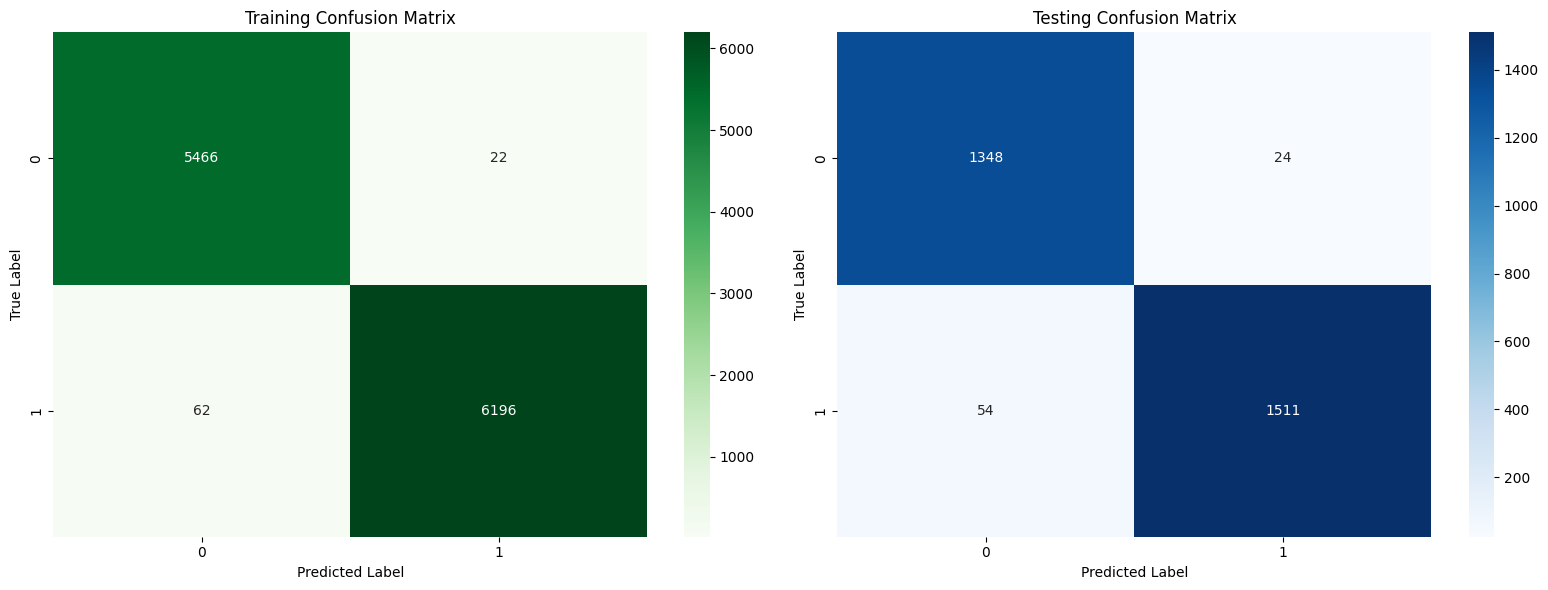

In [19]:
# After your preprocessing code
X_train, X_test, y_train, y_test = prepare_data(X_data, y_labels)

# Create and train model
#input_shape = X_train.shape[1:]  # (channels, height, width)
input_shape = (5, 256,17, 1)
model = create_2dcnn_lstm_model(input_shape)

history = train_model(model, X_train, y_train, X_test, y_test)

# Evaluate model
evaluate_model(model, X_train, y_train, X_test, y_test)

92/92 [==============================] - 20s 219ms/step


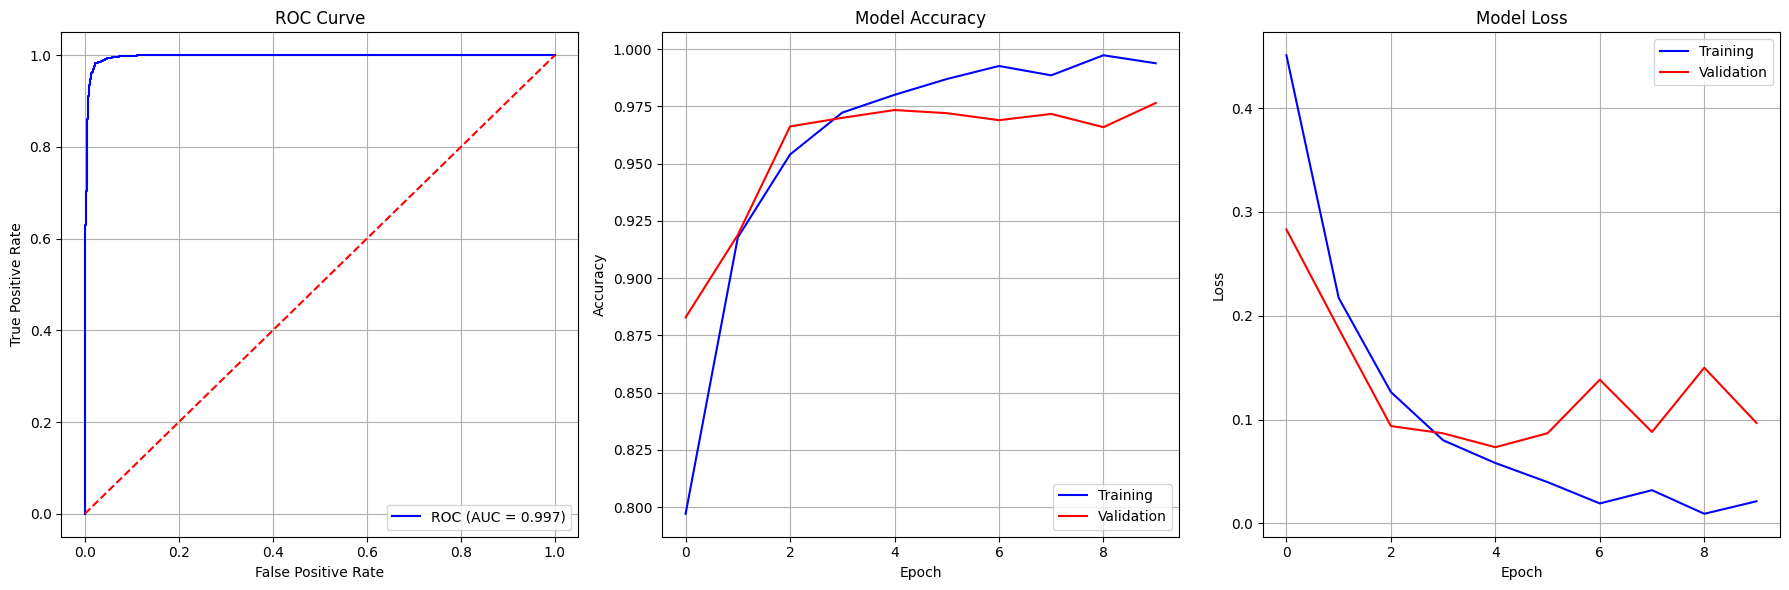

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np


def plot_training_history(history, y_test, X_test, model):
    # Get predictions for ROC curve
    y_pred = model.predict(X_test)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot 1: ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    axes[0].plot(fpr, tpr, 'b-', label=f'ROC (AUC = {roc_auc:.3f})')
    axes[0].plot([0, 1], [0, 1], 'r--')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend(loc='lower right')
    axes[0].grid(True)
    
    # Plot 2: Accuracy
    axes[1].plot(history.history['accuracy'], 'b-', label='Training')
    axes[1].plot(history.history['val_accuracy'], 'r-', label='Validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Model Accuracy')
    axes[1].legend(loc='lower right')
    axes[1].grid(True)
    
    # Plot 3: Loss
    axes[2].plot(history.history['loss'], 'b-', label='Training')
    axes[2].plot(history.history['val_loss'], 'r-', label='Validation')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].set_title('Model Loss')
    axes[2].legend(loc='upper right')
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

# Usage after training
plot_training_history(history, y_test, X_test, model)